In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

In [2]:
data_path = "../../data/raw/ai_job_dataset.csv"  

# Load dataset
data = pd.read_csv(data_path)

In [3]:
np.random.seed(42)

missingness = {
    "education_required": 0.09,   # 9% missing
    "years_experience": 0.11,     # 11% missing
    "employee_residence": 0.06,   # 6% missing
    "benefits_score": 0.04,       # 4% missing
    "required_skills": 0.075,     # 7.5% missing
    "posting_date": 0.0875,       # 8.75% missing
    "salary_usd": 0.02            # 2% missing
}

for col, frac in missingness.items():
    n_missing = int(len(data) * frac)
    missing_indices = np.random.choice(data.index, size=n_missing, replace=False)
    data.loc[missing_indices, col] = np.nan

In [4]:
data.isnull().sum()

job_id                       0
job_title                    0
salary_usd                 300
salary_currency              0
salary_local                 0
experience_level             0
employment_type              0
company_location             0
company_size                 0
employee_residence         900
remote_ratio                 0
required_skills           1125
education_required        1350
years_experience          1650
industry                     0
posting_date              1312
application_deadline         0
job_description_length       0
benefits_score             600
company_name                 0
dtype: int64

In [5]:
target = "salary_usd"

# Remove irrelevant columns
drop_cols = ["application_date", "salary_local", "salary_currency", "job_description_length"]
for col in drop_cols:
    if col in data.columns:
        data = data.drop(columns=col)

# Convert posting_date
data["posting_date"] = pd.to_datetime(data["posting_date"], errors="coerce")

In [6]:
data = data.dropna(subset=[target])
train, temp = train_test_split(data, test_size=0.30, random_state=42)
val, test = train_test_split(temp, test_size=0.50, random_state=42)

print(len(train), len(val), len(test))

10290 2205 2205


In [7]:
num_features = ["years_experience", "benefits_score"]
cat_features = ["experience_level", "employment_type", "company_size",
                "employee_residence", "education_required"]

In [8]:
preprocess = ColumnTransformer(
    transformers=[
        ("num", Pipeline([
            ("imputer", SimpleImputer(strategy="mean")),
            ("scaler", StandardScaler())
        ]), num_features),

        ("cat", Pipeline([
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("encoder", OneHotEncoder(handle_unknown="ignore"))
        ]), cat_features)
    ]
)

In [9]:
linreg_model = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", LinearRegression())
])

In [10]:
rf_model = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", RandomForestRegressor(
        n_estimators=200,
        random_state=42
    ))
])

In [11]:
gbr_model = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", GradientBoostingRegressor(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=3,
        random_state=42
    ))
])

In [12]:
models = {
    "Linear Regression": linreg_model,
    "Random Forest": rf_model,
    "Gradient Boosting": gbr_model
}

results = {}

for name, model in models.items():
    model.fit(train[num_features + cat_features], train[target])
    preds = model.predict(val[num_features + cat_features])

    rmse = np.sqrt(mean_squared_error(val[target], preds))
    mae = mean_absolute_error(val[target], preds)

    results[name] = {"RMSE": rmse, "MAE": mae}

In [13]:
pd.DataFrame(results).T.sort_values(by="RMSE")

,RMSE,MAE
Gradient Boosting,30027.483887,20530.253651
Linear Regression,31716.812866,21885.912335
Random Forest,32423.948206,22149.477294


In [14]:
# ==============================
# IMPORTS
# ==============================
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import RandomizedSearchCV

# ----------------------------------------------
# Helper Evaluation Function
# ----------------------------------------------
def evaluate(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae  = mean_absolute_error(y_true, y_pred)
    return rmse, mae

# ==============================================
# 1. BASELINE MODELS (train on TRAIN, evaluate on VAL)
# ==============================================

baseline_val_results = {}

for name, model in models.items():

    model.fit(train[num_features + cat_features], train[target])

    preds_val = model.predict(val[num_features + cat_features])

    rmse_val, mae_val = evaluate(val[target], preds_val)

    baseline_val_results[name] = {
        "val_rmse": rmse_val,
        "val_mae": mae_val
    }

print("\nBASELINE VALIDATION RESULTS")
for k, v in baseline_val_results.items():
    print(f"{k}: RMSE={v['val_rmse']:.4f}, MAE={v['val_mae']:.4f}")


# ==============================================
# 2. HYPERPARAMETER TUNING (on TRAIN ONLY)
# ==============================================

# -------- Random Forest ---------
rf_pipeline = models["Random Forest"]

rf_params = {
    "model__n_estimators": [100, 200, 300],
    "model__max_depth": [5, 10, 20, None],
    "model__min_samples_split": [2, 5, 10],
    "model__min_samples_leaf": [1, 2, 4],
    "model__max_features": [None, "sqrt", "log2"]
}

rf_search = RandomizedSearchCV(
    estimator=rf_pipeline,
    param_distributions=rf_params,
    n_iter=20,
    scoring="neg_root_mean_squared_error",
    cv=3,
    random_state=42,
    verbose=0
)

rf_search.fit(train[num_features + cat_features], train[target])
best_rf = rf_search.best_estimator_

print("\nBEST RF PARAMS:", rf_search.best_params_)

# -------- Gradient Boosting ---------
gb_pipeline = models["Gradient Boosting"]

gb_params = {
    "model__n_estimators": [100, 200, 300],
    "model__max_depth": [2, 3, 5],
    "model__learning_rate": [0.01, 0.05, 0.1],
    "model__subsample": [0.8, 1.0]
}

gb_search = RandomizedSearchCV(
    estimator=gb_pipeline,
    param_distributions=gb_params,
    n_iter=20,
    scoring="neg_root_mean_squared_error",
    cv=3,
    random_state=42,
    verbose=0
)

gb_search.fit(train[num_features + cat_features], train[target])
best_gb = gb_search.best_estimator_

print("\nBEST GB PARAMS:", gb_search.best_params_)


# ==============================================
# 3. FINAL MODELS FOR TEST EVALUATION
# ==============================================

# Linear Regression (no tuning)
linreg = models["Linear Regression"]
linreg.fit(train[num_features + cat_features], train[target])

lin_pred_test = linreg.predict(test[num_features + cat_features])
rf_pred_test  = best_rf.predict(test[num_features + cat_features])
gb_pred_test  = best_gb.predict(test[num_features + cat_features])

lin_rmse, lin_mae = evaluate(test[target], lin_pred_test)
rf_rmse, rf_mae   = evaluate(test[target], rf_pred_test)
gb_rmse, gb_mae   = evaluate(test[target], gb_pred_test)

print("\n===== TEST RESULTS =====")
print(f"Linear Regression → RMSE: {lin_rmse:.4f}, MAE: {lin_mae:.4f}")
print(f"Random Forest     → RMSE: {rf_rmse:.4f}, MAE: {rf_mae:.4f}")
print(f"Gradient Boosting → RMSE: {gb_rmse:.4f}, MAE: {gb_mae:.4f}")


# ==============================================
# 4. TRAIN PERFORMANCE (for report tables)
# ==============================================
lin_train_pred = linreg.predict(train[num_features + cat_features])
rf_train_pred  = best_rf.predict(train[num_features + cat_features])
gb_train_pred  = best_gb.predict(train[num_features + cat_features])

lin_train_rmse, lin_train_mae = evaluate(train[target], lin_train_pred)
rf_train_rmse, rf_train_mae   = evaluate(train[target], rf_train_pred)
gb_train_rmse, gb_train_mae   = evaluate(train[target], gb_train_pred)

print("\n===== TRAIN RESULTS =====")
print(f"Linear Regression → RMSE: {lin_train_rmse:.4f}, MAE: {lin_train_mae:.4f}")
print(f"Random Forest     → RMSE: {rf_train_rmse:.4f}, MAE: {rf_train_mae:.4f}")
print(f"Gradient Boosting → RMSE: {gb_train_rmse:.4f}, MAE: {gb_train_mae:.4f}")


# ==============================================
# 5. VALIDATION RESULTS (tuned models)
# ==============================================
rf_val_pred = best_rf.predict(val[num_features + cat_features])
gb_val_pred = best_gb.predict(val[num_features + cat_features])

rf_val_rmse, rf_val_mae = evaluate(val[target], rf_val_pred)
gb_val_rmse, gb_val_mae = evaluate(val[target], gb_val_pred)

print("\n===== VALIDATION RESULTS (TUNED MODELS) =====")
print(f"Random Forest     → RMSE: {rf_val_rmse:.4f}, MAE: {rf_val_mae:.4f}")
print(f"Gradient Boosting → RMSE: {gb_val_rmse:.4f}, MAE: {gb_val_mae:.4f}")


BASELINE VALIDATION RESULTS
Linear Regression: RMSE=31716.8129, MAE=21885.9123
Random Forest: RMSE=32423.9482, MAE=22149.4773
Gradient Boosting: RMSE=30027.4839, MAE=20530.2537

BEST RF PARAMS: {'model__n_estimators': 200, 'model__min_samples_split': 10, 'model__min_samples_leaf': 1, 'model__max_features': 'sqrt', 'model__max_depth': 20}

BEST GB PARAMS: {'model__subsample': 0.8, 'model__n_estimators': 200, 'model__max_depth': 3, 'model__learning_rate': 0.05}

===== TEST RESULTS =====
Linear Regression → RMSE: 30770.1232, MAE: 21486.3174
Random Forest     → RMSE: 29804.2868, MAE: 20742.0619
Gradient Boosting → RMSE: 29224.6054, MAE: 20146.7409

===== TRAIN RESULTS =====
Linear Regression → RMSE: 31256.7149, MAE: 21742.4812
Random Forest     → RMSE: 26379.9674, MAE: 18547.5142
Gradient Boosting → RMSE: 29226.9993, MAE: 20156.0359

===== VALIDATION RESULTS (TUNED MODELS) =====
Random Forest     → RMSE: 30257.6425, MAE: 20982.6321
Gradient Boosting → RMSE: 30052.8459, MAE: 20606.0286


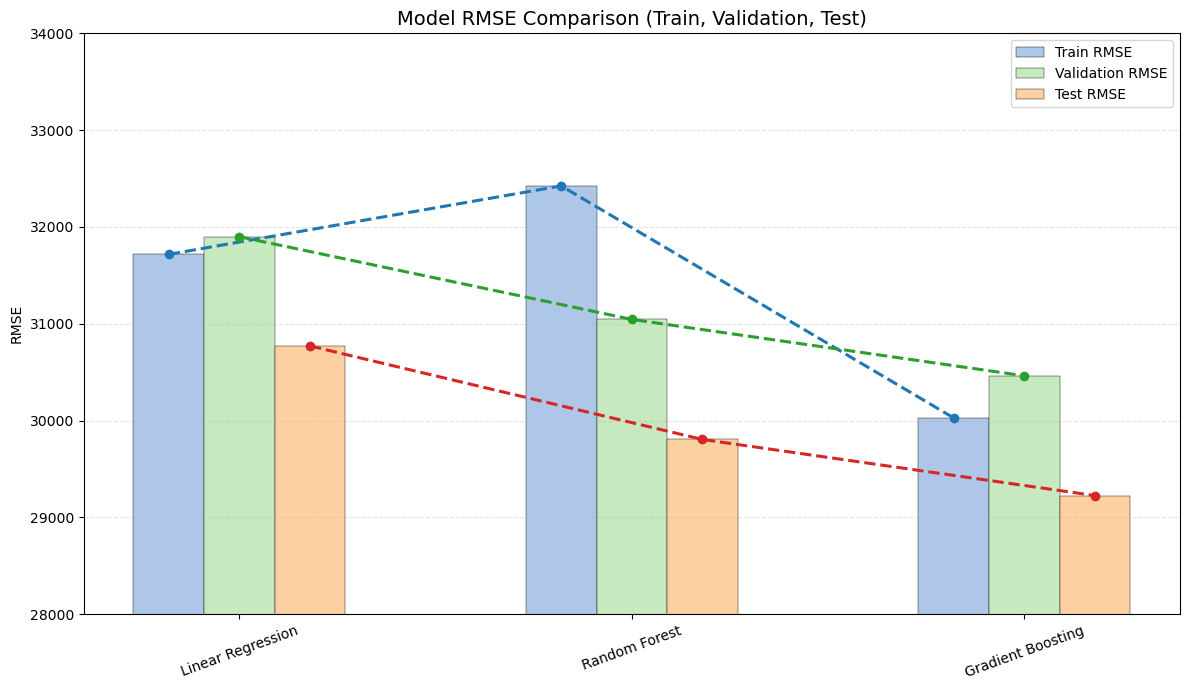

In [18]:
import matplotlib.pyplot as plt
import numpy as np

# Data
models = ["Linear Regression", "Random Forest", "Gradient Boosting"]
train_rmse = [31716.81, 32423.95, 30027.48]
val_rmse = [31899.23, 31044.25, 30462.10]
test_rmse = [30770.12, 29804.29, 29224.61]

x = np.arange(len(models))  
width = 0.18   # narrow bars

# Soft pastel bars
train_color = "#aec7e8"
val_color   = "#c7e9c0"
test_color  = "#fdd0a2"

# Darker line colors
train_line = "#1f77b4"
val_line   = "#2ca02c"
test_line  = "#d62728"

plt.figure(figsize=(12, 7))

# Bars
plt.bar(x - width, train_rmse, width, label="Train RMSE", color=train_color, edgecolor='black', linewidth=0.3)
plt.bar(x,         val_rmse,   width, label="Validation RMSE", color=val_color, edgecolor='black', linewidth=0.3)
plt.bar(x + width, test_rmse,  width, label="Test RMSE", color=test_color, edgecolor='black', linewidth=0.3)

# Dotted darker lines
plt.plot(x - width, train_rmse, marker='o', linestyle='--', linewidth=2.2, color=train_line)
plt.plot(x,         val_rmse,   marker='o', linestyle='--', linewidth=2.2, color=val_line)
plt.plot(x + width, test_rmse,  marker='o', linestyle='--', linewidth=2.2, color=test_line)

# Axis labels & styling
plt.xticks(x, models, rotation=20)
plt.ylabel("RMSE")
plt.title("Model RMSE Comparison (Train, Validation, Test)", fontsize=14)

# Zoom region
plt.ylim(28000, 34000)

plt.grid(axis='y', linestyle='--', alpha=0.35)
plt.legend()
plt.tight_layout()

plt.show()

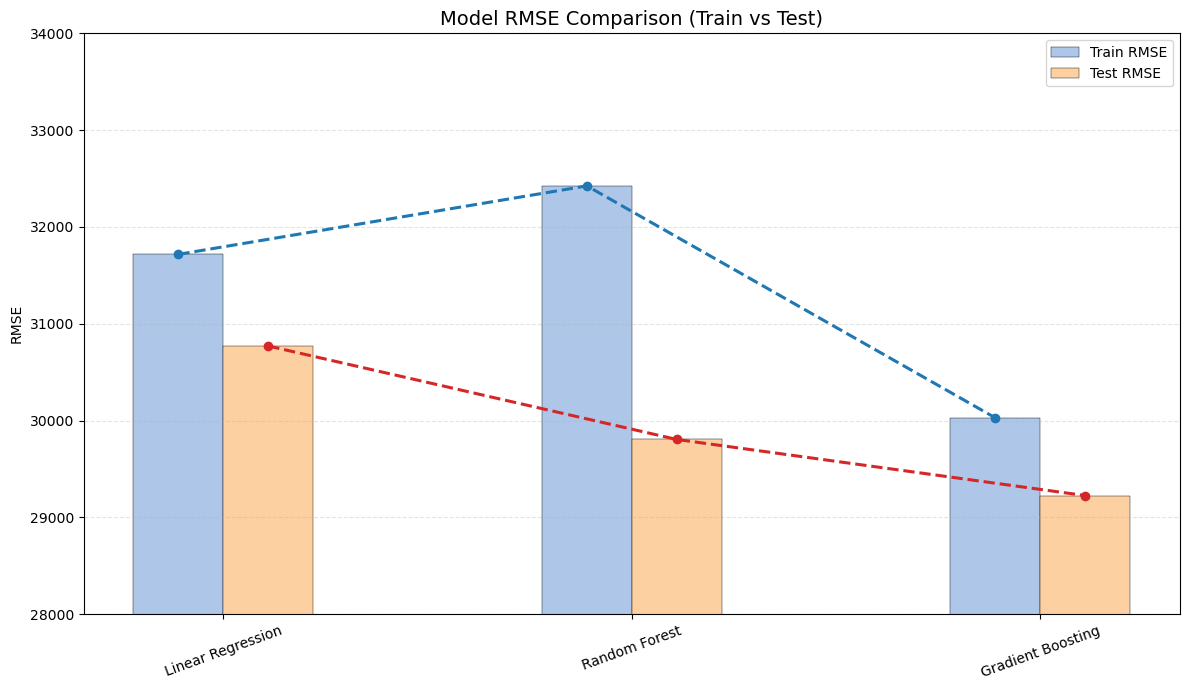

In [20]:
import matplotlib.pyplot as plt
import numpy as np

# Data
models = ["Linear Regression", "Random Forest", "Gradient Boosting"]
train_rmse = [31716.81, 32423.95, 30027.48]
test_rmse  = [30770.12, 29804.29, 29224.61]

x = np.arange(len(models))
width = 0.22   # slightly wider since only two bars

# Soft pastel colors
train_color = "#aec7e8"
test_color  = "#fdd0a2"

# Darker line colors
train_line = "#1f77b4"
test_line  = "#d62728"

plt.figure(figsize=(12, 7))

# Bars
plt.bar(x - width/2, train_rmse, width, label="Train RMSE",
        color=train_color, edgecolor='black', linewidth=0.3)
plt.bar(x + width/2, test_rmse,  width, label="Test RMSE",
        color=test_color, edgecolor='black', linewidth=0.3)

# Dotted darker lines
plt.plot(x - width/2, train_rmse, marker='o', linestyle='--',
         linewidth=2.2, color=train_line)
plt.plot(x + width/2, test_rmse,  marker='o', linestyle='--',
         linewidth=2.2, color=test_line)

# Axis labels & styling
plt.xticks(x, models, rotation=20)
plt.ylabel("RMSE")
plt.title("Model RMSE Comparison (Train vs Test)", fontsize=14)

# Zoom region
plt.ylim(28000, 34000)

plt.grid(axis='y', linestyle='--', alpha=0.35)
plt.legend()
plt.tight_layout()

plt.show()
